### SIM3 solver for coarse alignment of camera trajectory with GPS trajectory

In [152]:
import pickle
import glob
import copy
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

from transforms import affine_matrix_from_points, decompose_matrix, superimposition_matrix
from pytransform3d import rotations

import sys
sys.path.append("..")

In [153]:
def from_twist(twist):
    """Convert a 6D twist coordinate (shape (6,)) into a 3x3 rotation matrix
    and translation vector (shape (3,))."""
    r = twist[:3].reshape(3, 1)
    t = twist[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(r)
    return R, t

In [154]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))

gps_file = "../data_processing/splitted/gps/gps.json"
gps = json.load(open(gps_file, "r"))

In [155]:
nodes = list(sorted(pose_graph.nodes))#[:4]
nodes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

In [156]:
poses = [from_twist(pose_graph.nodes[node_id]["pose"]) for node_id in nodes]
positions = np.vstack([pose[1].reshape(3,) for pose in poses])

In [157]:
positions

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-8.14591492e-01, -9.09463210e-02, -5.72860775e-01],
       [-1.60537403e+00, -7.70502078e-03, -1.22880316e+00],
       [-2.82902626e+00,  4.04837377e-01, -1.56134414e+00],
       [-3.86044973e+00, -3.51031875e-02, -1.42410560e+00],
       [-4.97257062e+00, -5.83071390e-02, -1.24547158e+00],
       [-6.10695453e+00, -6.05864488e-02, -1.13936389e+00],
       [-7.13697960e+00, -6.60451978e-02, -1.09612323e+00],
       [-8.18644734e+00, -8.40801513e-02, -1.04876476e+00],
       [-9.29319499e+00, -9.86661580e-02, -1.04579151e+00],
       [-1.03106194e+01, -1.13147087e-01, -1.06564107e+00],
       [-1.13245181e+01, -1.26835312e-01, -1.08058530e+00],
       [-1.23966850e+01, -1.37184379e-01, -1.11768143e+00],
       [-1.34356304e+01, -1.52274175e-01, -1.14550233e+00],
       [-1.45610269e+01, -1.78384950e-01, -1.35129234e+00],
       [-1.57444085e+01, -2.01029522e-01, -1.48047741e+00],
       [-1.68865655e+01, -2.24636292e-01

In [158]:
# get GPS positions of each key frame
keyframe_idxs =  [int(pose_graph.nodes[node_id]["frame_name"][6:]) for node_id in nodes]
gps_positions = np.zeros((len(keyframe_idxs), 3))
gps_positions[:, 0:2] = np.array([gps[idx] for idx in keyframe_idxs])
gps_positions

array([[10.51974194, 49.32741556,  0.        ],
       [10.51973139, 49.32741556,  0.        ],
       [10.51972   , 49.32740778,  0.        ],
       [10.5197    , 49.32739639,  0.        ],
       [10.51968   , 49.32740028,  0.        ],
       [10.51966194, 49.32740389,  0.        ],
       [10.51966194, 49.32740389,  0.        ],
       [10.51963889, 49.32740778,  0.        ],
       [10.51961694, 49.32741167,  0.        ],
       [10.51959889, 49.32741167,  0.        ],
       [10.51958   , 49.32741167,  0.        ],
       [10.51958   , 49.32741167,  0.        ],
       [10.51955694, 49.32741167,  0.        ],
       [10.51953306, 49.32741167,  0.        ],
       [10.51950833, 49.32741167,  0.        ],
       [10.51950833, 49.32741167,  0.        ],
       [10.51948361, 49.32741167,  0.        ],
       [10.51945778, 49.32740778,  0.        ],
       [10.51945778, 49.32740778,  0.        ],
       [10.51943194, 49.32740778,  0.        ],
       [10.51940722, 49.32740778,  0.   

In [159]:
# compute scaling, rotation and translation between GPs trajectory and camera trajectory
affine = affine_matrix_from_points(positions.T, gps_positions.T, shear=False, scale=True, usesvd=True)
scale, _, angles, translate, _ = decompose_matrix(affine)
scale = scale[0]
scale, angles, translate

(1.5312240158658566e-05,
 [-1.7759397377950876, -0.028089352872472186, -0.05174011800382582],
 array([ 1.05197443e+01,  4.93274193e+01, -1.22120713e-06]))

In [160]:
# compute rotation matrix from Euler angles
R = rotations.active_matrix_from_extrinsic_euler_xyz(angles)
print(R)

[[ 0.99826783  0.0169248   0.05634623]
 [-0.05169663 -0.20485701  0.97742573]
 [ 0.02808566 -0.97864557 -0.20362721]]


In [161]:
positions *= scale
positions_mapped = np.matmul(R, positions.T).T + translate

In [162]:
positions_mapped

array([[ 1.05197443e+01,  4.93274193e+01, -1.22120713e-06],
       [ 1.05197314e+01,  4.93274117e+01,  1.57750157e-06],
       [ 1.05197187e+01,  4.93274023e+01,  2.03525084e-06],
       [ 1.05196998e+01,  4.93273970e+01, -3.63618057e-06],
       [ 1.05196841e+01,  4.93274012e+01,  2.08496505e-06],
       [ 1.05196672e+01,  4.93274048e+01,  1.39743093e-06],
       [ 1.05196500e+01,  4.93274073e+01,  6.12897644e-07],
       [ 1.05196343e+01,  4.93274088e+01,  1.16907729e-07],
       [ 1.05196183e+01,  4.93274104e+01, -2.11825213e-07],
       [ 1.05196013e+01,  4.93274114e+01, -4.78482406e-07],
       [ 1.05195858e+01,  4.93274119e+01, -6.37139062e-07],
       [ 1.05195703e+01,  4.93274125e+01, -8.21453127e-07],
       [ 1.05195538e+01,  4.93274129e+01, -1.01179445e-06],
       [ 1.05195379e+01,  4.93274133e+01, -1.14572771e-06],
       [ 1.05195205e+01,  4.93274112e+01, -5.96781822e-07],
       [ 1.05195023e+01,  4.93274103e+01, -3.63567934e-07],
       [ 1.05194847e+01,  4.93274092e+01

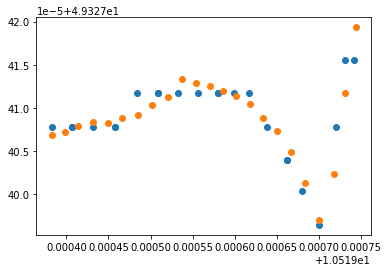

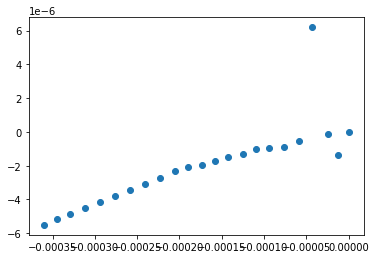

In [163]:
plt.scatter(gps_positions[:, 0], gps_positions[:, 1])
plt.scatter(positions_mapped[:, 0], positions_mapped[:, 1])
#plt.ylim([49.32739, 49.3275])
plt.show()
plt.scatter(positions[:, 0], positions[:, 1])
plt.show()